In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
import pyinaturalist as iNat
import os
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
roseObs = pd.read_csv("processedData/roseObs")
labeledRoseObs = roseObs.dropna()
labeledRoseObs["isFlowering"] = labeledRoseObs['reproductiveCondition'].isin(['flowering','flowering|fruiting','flowering|fruiting|flower budding','flowering|flower budding']).astype(int)
numList = []

for link in labeledRoseObs["references"]:
    numList.append(int(link.split("/")[-1]))

labeledRoseObs["observationNumber"] = numList
photos = labeledRoseObs[["observationNumber", "isFlowering"]].iloc[0:4000].reset_index(drop=True)


photoPath = "C:\\Users\\Sean Haight\\Desktop\\Coding\\Erdos Project\\Data Science\\Flower Identification Project\\photos\\roses"
photos_train, photos_val = train_test_split(list(photos.index), test_size=.2)
floweringTrainPath = "C:\\Users\\Sean Haight\\Desktop\\Coding\\Erdos Project\\Data Science\\Flower Identification Project\\photos\\roses\\train\\Flowering"
train_dir = 'C:\\Users\\Sean Haight\\Desktop\\Coding\\Erdos Project\\Data Science\\Flower Identification Project\\photos\\roses\\train'
val_dir = 'C:\\Users\\Sean Haight\\Desktop\\Coding\\Erdos Project\\Data Science\\Flower Identification Project\\photos\\roses\\val'
p_train= photos.iloc[photos_train]
p_val = photos.iloc[photos_val]

C:\Users\Sean Haight\AppData\Local\Temp\ipykernel_7464\3118870891.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeledRoseObs["isFlowering"] = labeledRoseObs['reproductiveCondition'].isin(['flowering','flowering|fruiting','flowering|fruiting|flower budding','flowering|flower budding']).astype(int)
C:\Users\Sean Haight\AppData\Local\Temp\ipykernel_7464\3118870891.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeledRoseObs["observationNumber"] = numList


In [3]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(75, 75, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
#LOOK AT FLOW_FROM_DATAFRAME
train_generator = train_datagen.flow_from_directory(
        'C:\\Users\\Sean Haight\\Desktop\\Coding\\Erdos Project\\Data Science\\Flower Identification Project\\photos\\roses\\train',  # This is the source directory for training images
        target_size=(75, 75),  # All images will be resized to 75x75
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
        'C:\\Users\\Sean Haight\\Desktop\\Coding\\Erdos Project\\Data Science\\Flower Identification Project\\photos\\roses\\val',  # This is the source directory for training images
        target_size=(75, 75),  # All images will be resized to 75x75
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=160,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=40,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15


C:\Users\Sean Haight\AppData\Local\Temp\ipykernel_7464\3457682046.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


160/160 - 6s - loss: 0.5244 - acc: 0.7169 - val_loss: 0.3628 - val_acc: 0.8637 - 6s/epoch - 40ms/step
Epoch 2/15
160/160 - 3s - loss: 0.3673 - acc: 0.8450 - val_loss: 0.5377 - val_acc: 0.7837 - 3s/epoch - 21ms/step
Epoch 3/15
160/160 - 3s - loss: 0.3218 - acc: 0.8725 - val_loss: 0.2693 - val_acc: 0.9075 - 3s/epoch - 21ms/step
Epoch 4/15
160/160 - 4s - loss: 0.2757 - acc: 0.8913 - val_loss: 0.2602 - val_acc: 0.9150 - 4s/epoch - 22ms/step
Epoch 5/15
160/160 - 3s - loss: 0.2563 - acc: 0.9003 - val_loss: 0.2488 - val_acc: 0.9150 - 3s/epoch - 21ms/step
Epoch 6/15
160/160 - 3s - loss: 0.2328 - acc: 0.9100 - val_loss: 0.2138 - val_acc: 0.9212 - 3s/epoch - 21ms/step
Epoch 7/15
160/160 - 3s - loss: 0.2013 - acc: 0.9206 - val_loss: 0.2263 - val_acc: 0.9325 - 3s/epoch - 21ms/step
Epoch 8/15
160/160 - 3s - loss: 0.1854 - acc: 0.9331 - val_loss: 0.2155 - val_acc: 0.9287 - 3s/epoch - 20ms/step
Epoch 9/15
160/160 - 4s - loss: 0.1573 - acc: 0.9422 - val_loss: 0.2454 - val_acc: 0.9212 - 4s/epoch - 23ms

Text(0.5, 1.0, 'Training and validation loss')

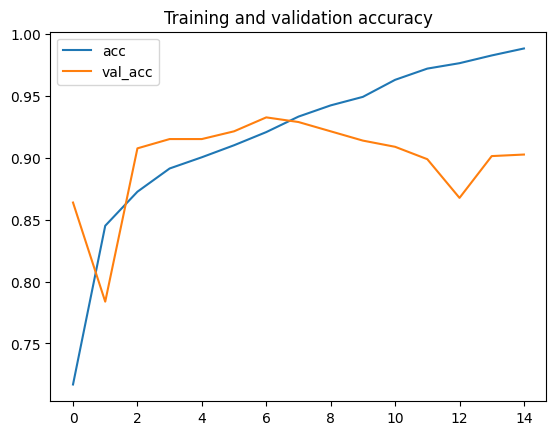

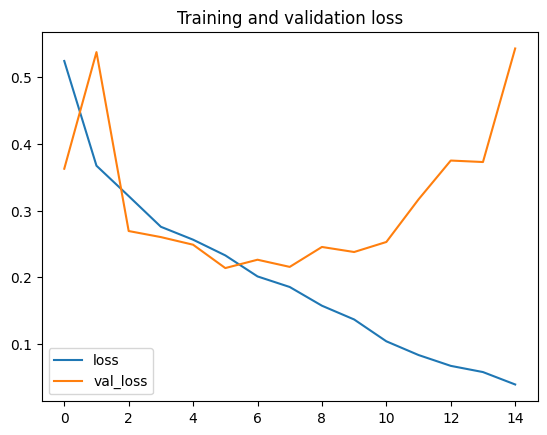

In [6]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label="acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label="loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.legend()
plt.title('Training and validation loss')

In [7]:
#Data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

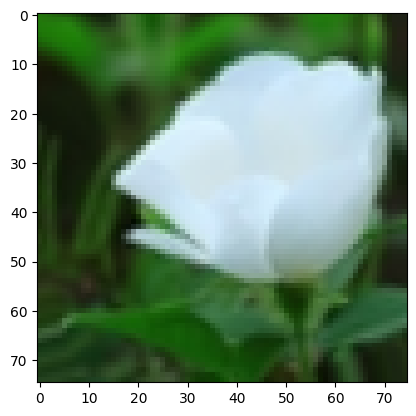

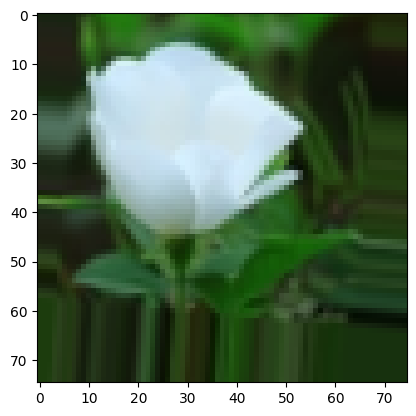

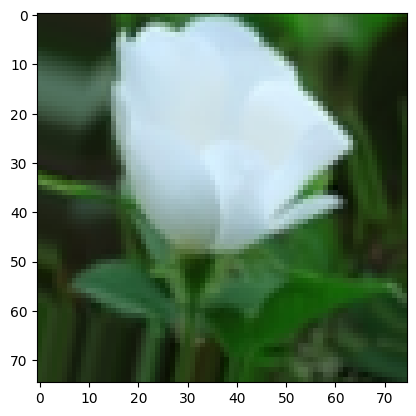

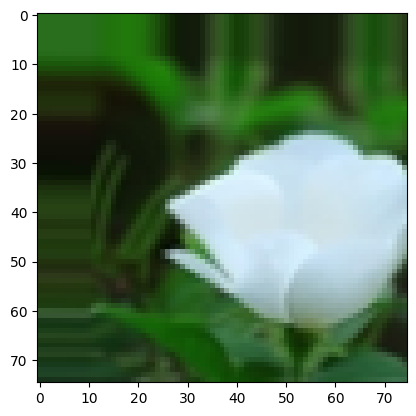

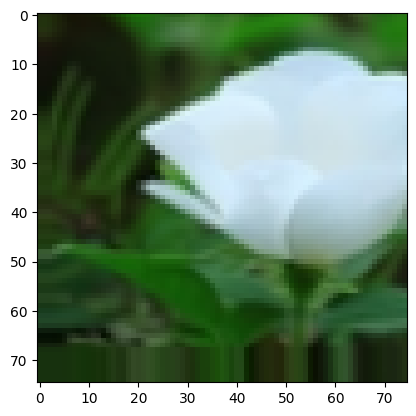

In [8]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
ind = 3

img_path = os.path.join(floweringTrainPath, str(p_train[p_train["isFlowering"] == 1].iloc[ind]['observationNumber']) + ".jpg")
img = load_img(img_path, target_size=(75, 75))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

In [9]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(75, 75),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(75, 75),
        batch_size=20,
        class_mode='binary')

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=160,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=40,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15


C:\Users\Sean Haight\AppData\Local\Temp\ipykernel_7464\3457682046.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


160/160 - 7s - loss: 0.3469 - acc: 0.8806 - val_loss: 0.2055 - val_acc: 0.9225 - 7s/epoch - 43ms/step
Epoch 2/15
160/160 - 7s - loss: 0.2823 - acc: 0.8947 - val_loss: 0.2030 - val_acc: 0.9200 - 7s/epoch - 45ms/step
Epoch 3/15
160/160 - 7s - loss: 0.2776 - acc: 0.9000 - val_loss: 0.2131 - val_acc: 0.9337 - 7s/epoch - 41ms/step
Epoch 4/15
160/160 - 7s - loss: 0.2631 - acc: 0.9075 - val_loss: 0.1796 - val_acc: 0.9337 - 7s/epoch - 42ms/step
Epoch 5/15
160/160 - 6s - loss: 0.2579 - acc: 0.9091 - val_loss: 0.1973 - val_acc: 0.9300 - 6s/epoch - 41ms/step
Epoch 6/15
160/160 - 7s - loss: 0.2526 - acc: 0.9094 - val_loss: 0.1559 - val_acc: 0.9413 - 7s/epoch - 44ms/step
Epoch 7/15
160/160 - 7s - loss: 0.2486 - acc: 0.9069 - val_loss: 0.1856 - val_acc: 0.9413 - 7s/epoch - 42ms/step
Epoch 8/15
160/160 - 7s - loss: 0.2394 - acc: 0.9091 - val_loss: 0.1687 - val_acc: 0.9475 - 7s/epoch - 44ms/step
Epoch 9/15
160/160 - 7s - loss: 0.2344 - acc: 0.9187 - val_loss: 0.1851 - val_acc: 0.9425 - 7s/epoch - 44ms

In [11]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(75, 75, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=160,  # 2000 images = batch_size * steps
      epochs=40,
      validation_data=validation_generator,
      validation_steps=40,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/40


C:\Users\Sean Haight\AppData\Local\Temp\ipykernel_7464\2695670165.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


160/160 - 7s - loss: 0.2260 - acc: 0.9191 - val_loss: 0.1655 - val_acc: 0.9463 - 7s/epoch - 41ms/step
Epoch 2/40
160/160 - 6s - loss: 0.2166 - acc: 0.9250 - val_loss: 0.1604 - val_acc: 0.9463 - 6s/epoch - 40ms/step
Epoch 3/40
160/160 - 6s - loss: 0.2170 - acc: 0.9259 - val_loss: 0.1778 - val_acc: 0.9450 - 6s/epoch - 39ms/step
Epoch 4/40
160/160 - 7s - loss: 0.2253 - acc: 0.9244 - val_loss: 0.1538 - val_acc: 0.9500 - 7s/epoch - 45ms/step
Epoch 5/40
160/160 - 7s - loss: 0.2205 - acc: 0.9244 - val_loss: 0.1499 - val_acc: 0.9563 - 7s/epoch - 42ms/step
Epoch 6/40
160/160 - 7s - loss: 0.2129 - acc: 0.9309 - val_loss: 0.1500 - val_acc: 0.9575 - 7s/epoch - 42ms/step
Epoch 7/40
160/160 - 7s - loss: 0.2122 - acc: 0.9241 - val_loss: 0.1377 - val_acc: 0.9600 - 7s/epoch - 45ms/step
Epoch 8/40
160/160 - 7s - loss: 0.2146 - acc: 0.9266 - val_loss: 0.1444 - val_acc: 0.9625 - 7s/epoch - 41ms/step
Epoch 9/40
160/160 - 6s - loss: 0.2134 - acc: 0.9266 - val_loss: 0.1435 - val_acc: 0.9588 - 6s/epoch - 40ms

Text(0.5, 1.0, 'Training and validation loss')

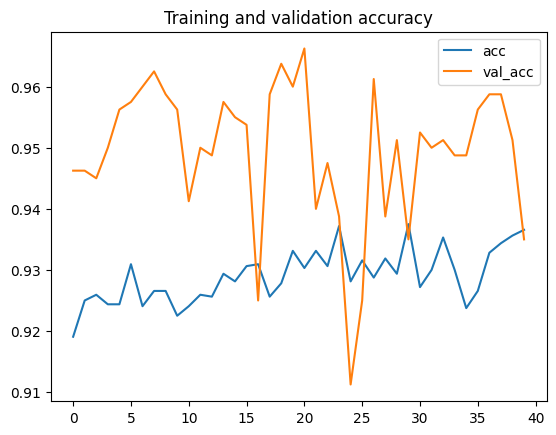

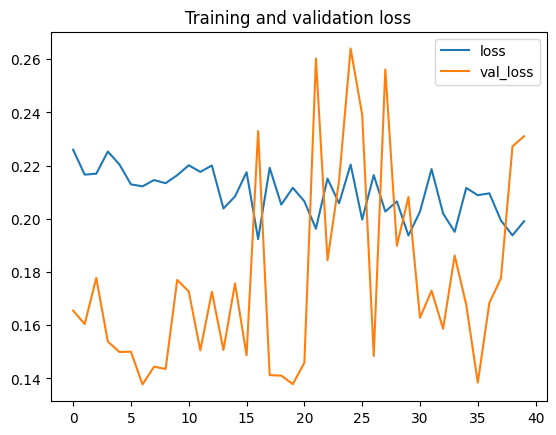

In [15]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label="acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label="loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.legend()
plt.title('Training and validation loss')